# Use case 2: Shower profiles

In [1]:
import showermodel as sm
import pandas as pd

This notebook illustrates how to use the following classes and their methods:
- `Atmosphere` : calculation of an atmospheric profile.
- `Profile` : calculation of a shower longitudinal profile.
- `Fluorescence` : calculation of the fluorescence production.
- `Cherenkov` : calculation of the Cherenkov light production.

These classes, along with the `Track` class described in UC1, are wrapped by the `Shower` class, which is also described here.

### Construction of an atmospheric profile

The default `Atmosphere` object uses the U.S. standard atmosphere, corresponding to model 1 in CORSIKA. The atmospheric model 17 of CORSIKA is also available. More models are to be implemented.  
The observation level, atmosphere discretization, etc. can be defined by the user.

In [2]:
# Default Atmosphere object
# atmosphere = sm.Atmosphere()

# Setting the observation level, the top of the atmosphere, the atmospheric model and the number of discretization steps
atmosphere = sm.Atmosphere(h0=1.8, h_top=100., model=17, N_steps=600)

The generated `Atmosphere` object is a subclass of `DataFrame` and it stores all the relevant parameters of the atmospheric profile.

In [4]:
atmosphere

,h,X_vert,rho,temp,P,P_w,E_th,r_M
0,1.881833,821.965364,1.018359e-03,275.794943,806.348022,0.0,23.426743,0.094323
1,2.045500,805.440347,1.001041e-03,274.925426,790.136980,0.0,23.628520,0.095954
2,2.209167,789.196339,9.840185e-04,274.040868,774.201608,0.0,23.832034,0.097614
3,2.372833,773.228562,9.672851e-04,273.141007,758.537220,0.0,24.037301,0.099303
4,2.536500,757.532320,9.508363e-04,272.225579,743.139206,0.0,24.244334,0.101021
...,...,...,...,...,...,...,...,...
595,99.263500,0.001372,1.269746e-09,369.184938,0.001346,0.0,20984.958249,75648.450808
596,99.427167,0.001351,1.241879e-09,371.814407,0.001326,0.0,21219.097993,77345.963977
597,99.590833,0.001331,1.214623e-09,374.502880,0.001306,0.0,21455.850152,79081.568486
598,99.754500,0.001312,1.187966e-09,377.251681,0.001287,0.0,21695.243874,80856.119088


It also has some useful attributes and methods.

In [5]:
print("Observation level in km a.s.l.:", atmosphere.h0)
print("Height (km a.s.l.) corresponding to a vertical depth of 50 g/cm2:", atmosphere.Xv_to_h(50.))

Observation level in km a.s.l.: 1.8
Height (km a.s.l.) corresponding to a vertical depth of 50 g/cm2: 20.699903736887787


Help on `Atmosphere`.

In [6]:
# atmosphere?

### Construction of shower profiles

The default `Profile` object assumes a Greisen function for a vertical shower induced by a gamma ray of 10 TeV in the default atmosphere. The depth of maximum is obtained from the Heitler model.

In [7]:
# profile = sm.Profile()

To set the shower parameters, the energy of the gamma ray should be given in MeV, the depth of maximum in g/cm$^2$ and both the zenith and azimuth angles in degrees.  
In addition, an `Atmosphere` object (or the parameters needed to construct it) can be input so that the shower profile is calculated for the specified atmospheric profile and discretization. This `Atmosphere` object is stored as an attribute of the `Profile` object.

In [8]:
# Greisen profile for a 1000 GeV shower (energy in MeV) with zenith angle of 20 degrees in the above-defined atmosphere
profile = sm.Profile(E=1000000., theta=20., X_max=300., atmosphere=atmosphere)

# Equivalent one-step procedure (without generating previously the atmosphere)
# profile = sm.Profile(E=1000000, theta=20., X_max=300., h0=1.8, h_top=100., model=17, N_steps=600)

# The atmosphere is stored as an attribute of profile
# profile.atmosphere

A Gaisser-Hillas profile can also be generated introducing the parameters `X_max`, `X0_GH` and `lambda_GH`. If `X0_GH` and `lambda_GH` are not given, they are interpolated from Auger data at the input shower energy.

In [9]:
# Gaisser-Hillas profile for a 1 EeV proton shower. A default value for lambda is used
# profile = sm.Profile(E=1.e12, theta=20., prf_model='Gaisser-Hillas', X_max=500., X0_GH=-10.)

`Profile` objects can also be constructed from a numerical energy deposit profile (e.g., obtained by CORSIKA). To do that, a `DataFrame` object has to be generated with two columns: slant depth in g/cm2 and dE/dX in MeV.cm2/g

In [10]:
# Numerical energy deposit profile generated by CORSIKA: average of 1000 vertical showers induced by 1000 GeV gamma rays
prf_model = pd.read_fwf('../extra/Edep_profile_1000GeV_1000sh_0deg.dat', skiprows = 12, names=['X', 'dE_dX'])
prf_model.dE_dX *= 1000./10.  # Original data is given in GeV in steps of 10 g/cm2

profile2 = sm.Profile(E=1000000., theta=0., prf_model=prf_model)

`Profile` objects have a method to plot both the number of charged particles (with energy above 1 MeV) and the energy deposit profile in MeV.cm$^2$/g as a function of slant depth in g/cm$^2$

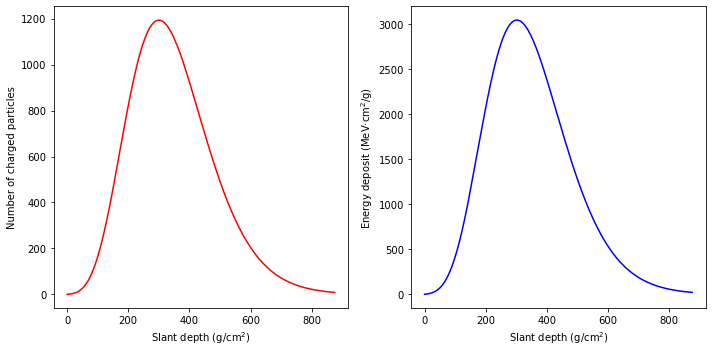

In [11]:
profile.show();

The generated plots can be stored in `AxesSubplot` objects for later modification.

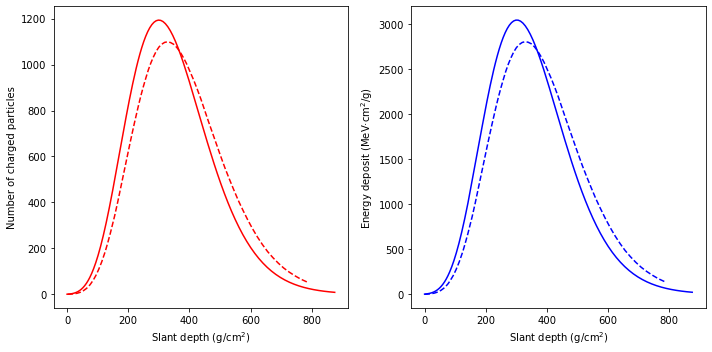

In [12]:
# Example of comparison of two profiles in the same plot
ax1, ax2 = profile.show();
ax1.plot(profile2.X, profile2.N_ch, 'r--');
ax2.plot(profile2.X, profile2.E_dep/profile2.dX, 'b--');

Help on `Profile`.

In [13]:
# sm.Profile?

### Fluorescence and Cherenkov light production

One can construct `Fluorescence` and `Cherenkov` objects that contain calculations of both light components in the 290 - 430 nm range, based on available models for a 1D shower profile.  
Cherenkov -> F. Nerling et al., Astropart. Phys. 24(2006)241.  
Fluorescence -> D. Morcuende et al., Astropart. Phys. 107(2019)26 and references therein.

In [15]:
fluorescence = sm.Fluorescence(profile)
cherenkov = sm.Cherenkov(profile)

# Equivalent methods of Profile
# fluorescence = profile.Fluorescence()
# cherenkov = profile.Cherenkov()

The generated objects are subclasses of `DataFrame`.

In [16]:
# fluorescence
cherenkov

,N_ph,a,theta_c,b,theta_cc
0,9469.041850,1.202737,5.314228,0.065348,9.091585
1,11720.851089,1.198439,5.286685,0.063783,9.429516
2,14419.088354,1.194075,5.259285,0.062232,9.766305
3,17631.012370,1.189646,5.232027,0.060696,10.101912
4,21429.502389,1.185151,5.204910,0.059176,10.436295
...,...,...,...,...,...
595,0.000694,0.424894,0.086438,0.055107,0.908373
596,0.000676,0.424894,0.085859,0.055107,0.902287
597,0.000658,0.424894,0.085284,0.055107,0.896241
598,0.000641,0.424894,0.084712,0.055107,0.890236


These objects include methods to plot the light production as a function of slant depth.

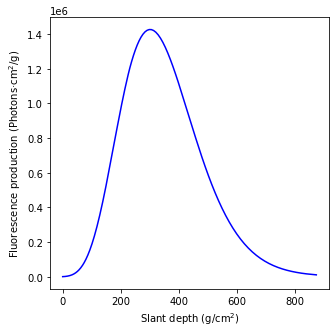

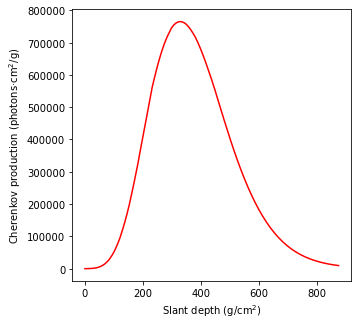

In [17]:
fluorescence.show();
cherenkov.show();

The fluorescence light production is evaluated at 34 bands.

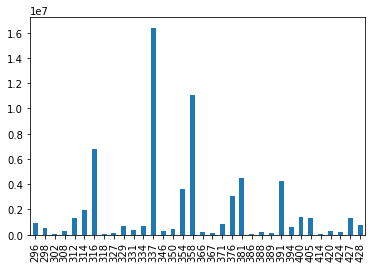

In [18]:
fluorescence.sum().plot(kind='bar');

Help on `Fluorescence` and `Cherenkov`.

In [19]:
# fluorescence?
# cherenkov?

### `Shower` objects

A `Shower` object contains a `Track` object, a `Profile` object and both `Fluorescence` and `Cherenkov` objects corresponding to a given shower and atmospheric profile. This can be generated in one step introducing all the needed parameters (or keeping the default ones).

In [20]:
# Default Shower object
# shower = sm.Shower()

# Setting the impact point, energy, zenith and azimuth angles, X_max and atmospheric profile
shower = sm.Shower(x0=0.5, y0=0.1, E=1000000, theta=20., az= 30., X_max=300., h0=1.8, h_top=100., model=17, N_steps=600)

The constituent objects are attributes of `Shower`.

In [21]:
shower.atmosphere  # Equivalent to shower.profile.atmosphere
# shower.track
# shower.profile
# shower.fluorescence
# shower.cherenkov

,h,X_vert,rho,temp,P,P_w,E_th,r_M
0,1.881833,821.965364,1.018359e-03,275.794943,806.348022,0.0,23.426743,0.094323
1,2.045500,805.440347,1.001041e-03,274.925426,790.136980,0.0,23.628520,0.095954
2,2.209167,789.196339,9.840185e-04,274.040868,774.201608,0.0,23.832034,0.097614
3,2.372833,773.228562,9.672851e-04,273.141007,758.537220,0.0,24.037301,0.099303
4,2.536500,757.532320,9.508363e-04,272.225579,743.139206,0.0,24.244334,0.101021
...,...,...,...,...,...,...,...,...
595,99.263500,0.001372,1.269746e-09,369.184938,0.001346,0.0,20984.958249,75648.450808
596,99.427167,0.001351,1.241879e-09,371.814407,0.001326,0.0,21219.097993,77345.963977
597,99.590833,0.001331,1.214623e-09,374.502880,0.001306,0.0,21455.850152,79081.568486
598,99.754500,0.001312,1.187966e-09,377.251681,0.001287,0.0,21695.243874,80856.119088


Some attributes of `Track`, `Profile` and `Atmosphere` can also be accessed via attributes of `Shower`.

In [22]:
print("Depth of maximum:", shower.X_max)  # Equivalent to shower.profile.X_max
print("Coordinates of ground interaction point:", (shower.x0, shower.y0))  # Equivalent to (shower.track.x0, shower.track.y0)

Depth of maximum: 300.0
Coordinates of ground interaction point: (0.5, 0.1)


There are some inherited methods as well.

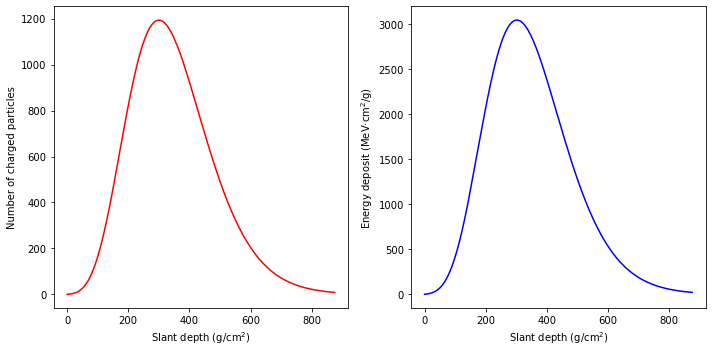

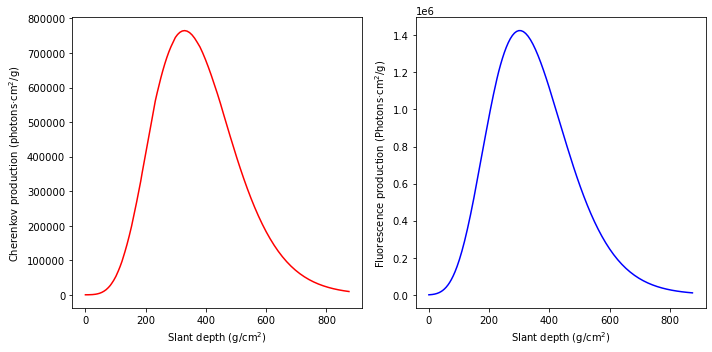

In [23]:
shower.show_profile();
shower.show_light_production();

Remarkably, there is a method of `Shower` to visualize the shower track projection with additional options with respect to the equivalent method of `Projection`.

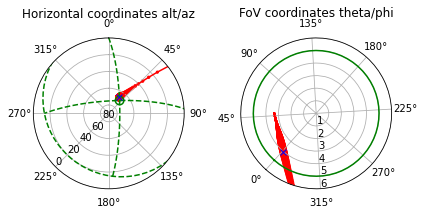

In [24]:
shower.show_projection(sm.Telescope(x=0.1, y=-0.2, z=0.1, alt=70., az=40.), max_theta=6.);

# Equivalent procedure
# telescope = sm.Telescope(x=0.1, y=-0.2, z=0.1, alt=70., az=40.)
# projection = shower.Projection(telescope)
# projection.show(max_theta=6., X_mark=shower.X_max);

Note 1: `X_mark` is set to `X_max` by default.  
Note 2: Size of track points are proportional to shower size (i.e., column `N_ch` of the `Profile` object).

There is also a method to make copies of a `Shower` object with optional changes.

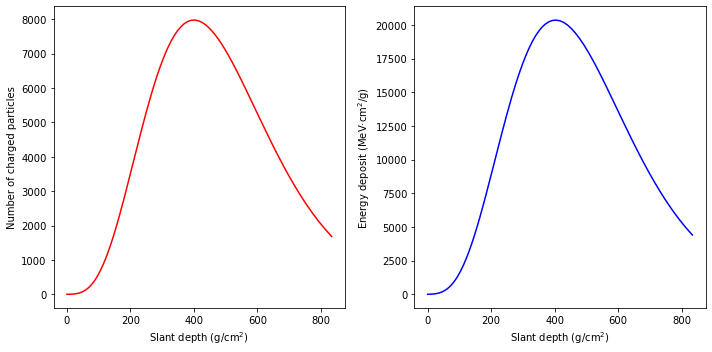

In [25]:
# Identical copy
# shower2 = shower.copy()

# Same atmosphere and track, but different profile
shower2 = shower.copy(E=10000000., X_max=400.,prf_model='Gaisser-Hillas')
shower2.show_profile();

Help on `Shower`.

In [26]:
# sm.Shower?